<a href="https://colab.research.google.com/github/Mollylst/Machine-Learning-Collection/blob/master/regression_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -uq '/content/drive/MyDrive/data 8:1:1/train_fake.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/data 8:1:1/train_real.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/data 8:1:1/test_fake.zip' -d /content/test
!unzip -uq '/content/drive/MyDrive/data 8:1:1/test_real.zip' -d /content/test

In [ ]:
!rm -rf my_che /content/celeba_low_1000.pkl

In [6]:
import numpy as np
from PIL import Image
from scipy import fftpack

def image_label(imageLabel, label2idx, i):
    """return label of image
    """
    if imageLabel not in label2idx:
        label2idx[imageLabel]=i
        i = i + 1
    return label2idx, i
    
def dct2(array):
    array = fftpack.dct(array, type=2, norm="ortho", axis=0)
    array = fftpack.dct(array, type=2, norm="ortho", axis=1)
    return array

def log_scale(array, epsilon=1e-12):
    """Log scale the input array.
    """
    array = np.abs(array)
    array += epsilon  # no zero in log
    array = np.log(array)
    return array

In [42]:
import cv2
import os
import numpy as np
import random

def image2npy(dir_path='/content/train', testScale = 0.2):
    
    i = 0
    label2idx = {}
    data = []
    for (root, dirs, files) in os.walk(dir_path):
        for file in files: 
            img_path = os.path.join(root, file) 
            File = root.split('/')[-1] #name of the file which is label
            
            img_data = cv2.imread(img_path,0)

            image = np.asarray(img_data)
            image = dct2(image)
            img_data = log_scale(image)

            label2idx, i = image_label(File, label2idx, i)
            label = label2idx[File]
            
            data.append([np.array(img_data), label])
    random.shuffle(data) 
    # split train and test data
    testNum = int(len(data)*testScale)
    train_data = data[:-1*testNum] 
    test_data = data[-1*testNum:] 

    X_train = np.array([i[0] for i in train_data]) # train feature
    y_train = np.array([i[1] for i in train_data]) # train label
    X_test = np.array([i[0] for i in test_data]) 
    y_test = np.array([i[1] for i in test_data]) 
    print(len(X_train), len(y_train), len(X_test), len(y_test))

    np.save('drive/MyDrive/train-images-idx3.npy', X_train)
    np.save('drive/MyDrive/train-labels-idx1.npy', y_train)
    np.save('drive/MyDrive/t10k-images-idx3.npy', X_test)
    np.save('drive/MyDrive/t10k-labels-idx1.npy', y_test)
    return label2idx

image2npy()

14400 14400 3600 3600


{'fake': 1, 'real': 0}

(3600, 128, 128) (3600,)


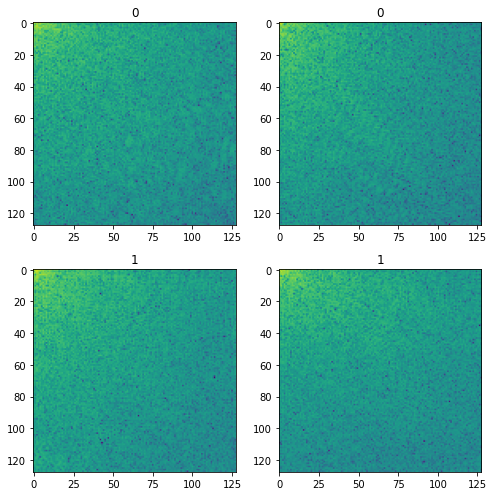

In [47]:
import matplotlib.pyplot as plt

image_no = np.random.randint(0,1800, size=4) 
test_images = np.load('./drive/MyDrive/t10k-images-idx3.npy')
test_labels = np.load('./drive/MyDrive/t10k-labels-idx1.npy')
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(7,7))
for i in range(2):
    for j in range(2):
        axes[i][j].imshow(test_images[image_no[i*2+j]])
        axes[i][j].set_title(test_labels[image_no[i*2+j]])
plt.tight_layout()
print(test_images.shape,test_labels.shape)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pickle

train_images = np.load('./drive/MyDrive/train-images-idx3.npy')
train_labels = np.load('./drive/MyDrive/train-labels-idx1.npy')
test_images = np.load('./drive/MyDrive/t10k-images-idx3.npy')
test_labels = np.load('./drive/MyDrive/t10k-labels-idx1.npy')
    
nsamples, nx, ny = train_images.shape
train_images = train_images.reshape((nsamples,nx*ny))
print(train_images.shape)

msamples, mx, my = test_images.shape
test_images = test_images.reshape((msamples,mx*my))
    
logisticRegr = LogisticRegression(solver='liblinear', max_iter=1000)
logisticRegr.fit(train_images, train_labels)
score = logisticRegr.score(test_images, test_labels)
print(score)

(14400, 16384)
0.5216666666666666


In [2]:
import torch
import torchvision
import os
import numpy as np
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data import random_split

train_images = np.load('./drive/MyDrive/train-images-idx3.npy')
train_labels = np.load('./drive/MyDrive/train-labels-idx1.npy')
test_images = np.load('./drive/MyDrive/t10k-images-idx3.npy')
test_labels = np.load('./drive/MyDrive/t10k-labels-idx1.npy')

X_train = torch.from_numpy(train_images).float() 
X_test = torch.from_numpy(test_images).float()
Y_train = torch.from_numpy(train_labels).long() 
Y_test = torch.from_numpy(test_labels).long()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

MINIBATCH_SIZE = 128

trainDataset = torch.utils.data.TensorDataset(X_train, Y_train) 
trainloader = torch.utils.data.DataLoader(
    dataset=trainDataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2          # set multi-work num read data
)

testDataset = torch.utils.data.TensorDataset(X_test, Y_test) 
testloader = torch.utils.data.DataLoader(
    dataset=testDataset,
    batch_size=MINIBATCH_SIZE, 
    shuffle=False, 
    num_workers=2 
)

torch.Size([14400, 128, 128]) torch.Size([14400])
torch.Size([3600, 128, 128]) torch.Size([3600])


In [26]:
import torch.nn as nn
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(input_size, num_classes)

In [27]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

input_size = 128*128
num_classes = 2
num_epochs = 5
batch_size = 118
learning_rate= 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/5], Step [100/113], Loss: 16.2364
Epoch [2/5], Step [100/113], Loss: 22.2785
Epoch [3/5], Step [100/113], Loss: 19.0323
Epoch [4/5], Step [100/113], Loss: 13.7419
Epoch [5/5], Step [100/113], Loss: 9.8279
Accuracy of the model on the 10000 test images: 50.91666793823242 %


In [18]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0, last_epoch=-1, verbose=False)

Epoch: 1/50
Epoch: 001, Training: Loss: 255.0912, Accuracy: 49.7083%, 
		Validation: Loss: 104.9717, Accuracy: 49.8333%, Time: 3.1608s
Best Accuracy for validation : 0.4983 at epoch 001
Epoch: 2/50
Epoch: 002, Training: Loss: 204.4608, Accuracy: 51.4514%, 
		Validation: Loss: 81.6069, Accuracy: 50.8056%, Time: 1.9317s
Best Accuracy for validation : 0.5081 at epoch 002
Epoch: 3/50
Epoch: 003, Training: Loss: 144.1471, Accuracy: 53.0972%, 
		Validation: Loss: 356.2355, Accuracy: 49.8333%, Time: 1.7319s
Best Accuracy for validation : 0.5081 at epoch 002
Epoch: 4/50
Epoch: 004, Training: Loss: 64.7469, Accuracy: 59.6111%, 
		Validation: Loss: 78.0600, Accuracy: 50.2778%, Time: 2.2232s
Best Accuracy for validation : 0.5081 at epoch 002
Epoch: 5/50
Epoch: 005, Training: Loss: 144.0888, Accuracy: 55.2153%, 
		Validation: Loss: 77.1385, Accuracy: 52.5833%, Time: 1.7329s
Best Accuracy for validation : 0.5258 at epoch 005
Epoch: 6/50
Epoch: 006, Training: Loss: 38.1153, Accuracy: 66.6736%, 
		Va

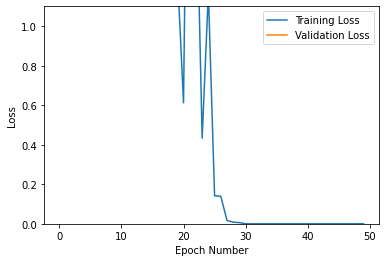

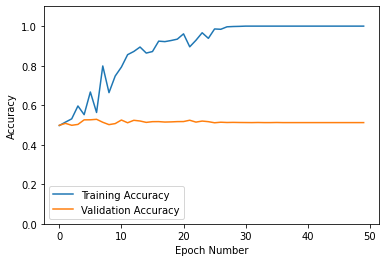

In [19]:
import time
num_epoch=50
path='./deepfake.pth'

def train_and_valid():
    history = []
    best_acc = 0.0
    best_epoch = 0
    input_size = 128*128
    num_classes = 2

    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))
        
        # Try save checkpoint
        #if epoch==49:
          #checkpoint = {"state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
          #save_checkpoint(checkpoint)

        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.reshape(-1, 128*128)
 
            #the gradient is increasing, so make it zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        #test
        model.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(testloader):

                inputs = inputs.reshape(-1, 128*128)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _,predictions = torch.max(outputs.data, 1)
                #total += labels.size(0)
                valid_acc += (predictions == labels).sum().item()
 
        avg_train_loss = train_loss/ len(trainDataset)
        avg_train_acc = train_acc/ len(trainDataset)
 
        avg_valid_loss = valid_loss/ len(testDataset)
        avg_valid_acc = valid_acc/ len(testDataset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(),path)
        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
          
    return history
    
#start training and testing
history = train_and_valid()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()